In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

'''import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"import os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [23]:
if torch.cuda.is_available():
    device = 'cuda'
    print("CUDA is available. Models will be moved to GPU.")
else:
    device = 'cpu'
    print("CUDA is not available. Models will be moved to CPU.")

CUDA is available. Models will be moved to GPU.


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

class HazyDataset(Dataset):
    def __init__(self, folders, transform=None):
        self.folders = folders
        self.transform = transform

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        folder = self.folders[idx]

        hazy_image_path = os.path.join(folder, 'hazy.jpg')
        clear_image_path = os.path.join(folder, 'original.jpg')

        hazy_image = Image.open(hazy_image_path).convert('RGB')
        clear_image = Image.open(clear_image_path).convert('RGB')

        if self.transform:
            hazy_image = self.transform(hazy_image)
            clear_image = self.transform(clear_image)

        return hazy_image, clear_image


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


folders = [f'/kaggle/input/dehazing-and-desmoking/dataset/{i}' for i in range(50000)]
dataset = HazyDataset(folders=folders, transform=transform)
dataloader = DataLoader(
    dataset,         
    batch_size=32,   
    shuffle=True,    
    num_workers=4,  
    pin_memory=True
)

In [25]:

class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        
        def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
                nn.LeakyReLU(0.2, inplace=True)
            )
        
        def upconv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.LeakyReLU(0.2, inplace=True)
            )
        
        self.down1 = conv_block(3, 64)
        self.down2 = conv_block(64, 128)
        self.down3 = conv_block(128, 256)
        self.down4 = conv_block(256, 512)
        self.down5 = conv_block(512, 1024)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        self.up4 = upconv_block(1024, 512)
        self.up3 = upconv_block(1024, 256)
        self.up2 = upconv_block(512, 128)
        self.up1 = upconv_block(256, 64)
        
        self.final_conv = nn.Conv2d(128, 3, kernel_size=1)
    
    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.maxpool(d1)
        
        d2 = self.down2(p1)
        p2 = self.maxpool(d2)
        
        d3 = self.down3(p2)
        p3 = self.maxpool(d3)
        
        d4 = self.down4(p3)
        p4 = self.maxpool(d4)
        
        d5 = self.down5(p4)
        
        u4 = self.up4(d5)
        u4 = torch.cat([u4, d4], dim=1)  
        
        u3 = self.up3(u4)
        u3 = torch.cat([u3, d3], dim=1)  
        
        u2 = self.up2(u3)
        u2 = torch.cat([u2, d2], dim=1)  
        
        u1 = self.up1(u2)
        u1 = torch.cat([u1, d1], dim=1)  
        
        return torch.sigmoid(self.final_conv(u1))


In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        def discriminator_block(in_channels, out_channels, stride=2):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.4)
            )
        
        self.model = nn.Sequential(
            discriminator_block(3, 32),
            discriminator_block(32, 64),
            discriminator_block(64, 128),
            discriminator_block(128, 256),
            discriminator_block(256, 512),
            discriminator_block(512, 1024),
            nn.Flatten(),
            nn.Linear(1024 * 4 * 4, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

In [27]:
generator = UNetGenerator().to('cuda')
discriminator = Discriminator().to('cuda')

In [28]:
criterion = nn.BCELoss()
mse_loss = nn.MSELoss()
gen_optimizer = optim.Adam(generator.parameters(), lr=0.0001)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=0.00001)

In [29]:
epochs = 10

for epoch in range(epochs):
    for i, (hazy_imgs, clear_imgs) in enumerate(dataloader):
        hazy_imgs, clear_imgs = hazy_imgs.to('cuda'), clear_imgs.to('cuda')
        
        disc_optimizer.zero_grad()

        fake_imgs = generator(hazy_imgs)
        real_preds = discriminator(clear_imgs)
        fake_preds = discriminator(fake_imgs.detach())
        
        real_labels = torch.ones_like(real_preds)
        fake_labels = torch.zeros_like(fake_preds)
        
        d_loss_real = criterion(real_preds, real_labels)
        d_loss_fake = criterion(fake_preds, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        
        d_loss.backward()
        disc_optimizer.step()

        gen_optimizer.zero_grad()
        
        fake_preds = discriminator(fake_imgs)
        g_loss_adv = criterion(fake_preds, real_labels)
        g_loss_recon = mse_loss(fake_imgs, clear_imgs)
        g_loss = g_loss_adv + g_loss_recon
        
        g_loss.backward()
        gen_optimizer.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}], Step [{i}/{len(dataloader)}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

    torch.save(generator.state_dict(), 'generator.pth')
    torch.save(discriminator.state_dict(), 'discriminator.pth')

Epoch [0/10], Step [0/1563], D Loss: 1.386326551437378, G Loss: 0.7674059271812439
Epoch [0/10], Step [100/1563], D Loss: 1.386979579925537, G Loss: 0.7144026160240173
Epoch [0/10], Step [200/1563], D Loss: 1.3866705894470215, G Loss: 0.7134537100791931
Epoch [0/10], Step [300/1563], D Loss: 1.3869342803955078, G Loss: 0.709770143032074
Epoch [0/10], Step [400/1563], D Loss: 1.3840733766555786, G Loss: 0.7095261812210083
Epoch [0/10], Step [500/1563], D Loss: 1.3851382732391357, G Loss: 0.7105966210365295
Epoch [0/10], Step [600/1563], D Loss: 1.385909080505371, G Loss: 0.7074012160301208
Epoch [0/10], Step [700/1563], D Loss: 1.387371301651001, G Loss: 0.710498034954071
Epoch [0/10], Step [800/1563], D Loss: 1.3876298666000366, G Loss: 0.7093770503997803
Epoch [0/10], Step [900/1563], D Loss: 1.3875600099563599, G Loss: 0.7104185819625854
Epoch [0/10], Step [1000/1563], D Loss: 1.3872395753860474, G Loss: 0.7073972225189209
Epoch [0/10], Step [1100/1563], D Loss: 1.3864622116088867, G

In [30]:
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

/tmp/ipykernel_30/91245702.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('generator.pth'))


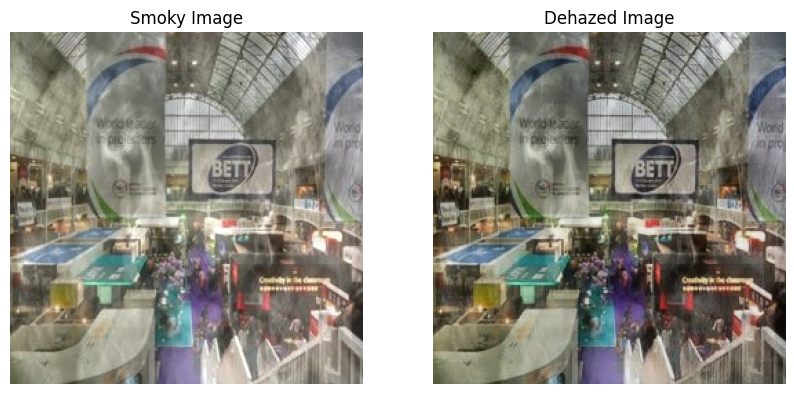

In [32]:
generator = UNetGenerator().to('cuda')
generator.load_state_dict(torch.load('generator.pth'))
generator.eval()


def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    image = transform(image).unsqueeze(0)  
    return image.to('cuda')


def postprocess_image(output_tensor):
    output_image = output_tensor.squeeze(0).detach().cpu().numpy() 
    output_image = np.transpose(output_image, (1, 2, 0))  
    output_image = (output_image * 255).astype(np.uint8)  
    return Image.fromarray(output_image)

def test_model_on_image(smoky_image_path):
    
    smoky_image = preprocess_image(smoky_image_path)
    
    
    with torch.no_grad():  
        clear_image = generator(smoky_image)
    
    
    clear_image = postprocess_image(clear_image)
    
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    original_image = Image.open(smoky_image_path).convert('RGB')
    axs[0].imshow(original_image)
    axs[0].set_title('Smoky Image')
    axs[0].axis('off')
    
    axs[1].imshow(clear_image)
    axs[1].set_title('Dehazed Image')
    axs[1].axis('off')
    
    plt.show()


test_image_path = '/kaggle/input/testing2/testimg2.jpg'

test_model_on_image(test_image_path)

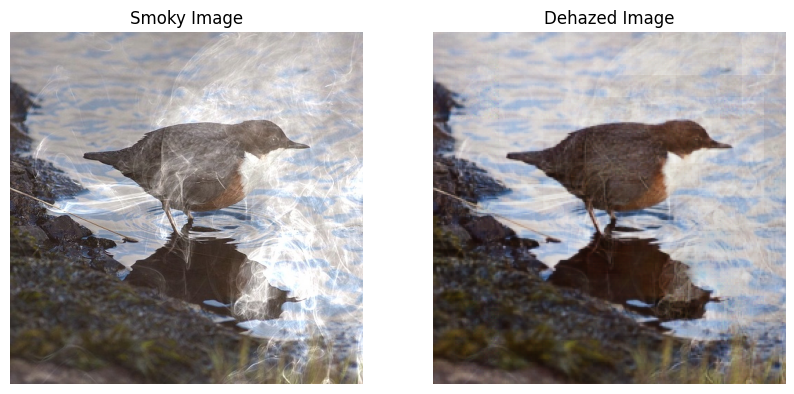

In [33]:
test_model_on_image('/kaggle/input/testing/testimg.jpg')

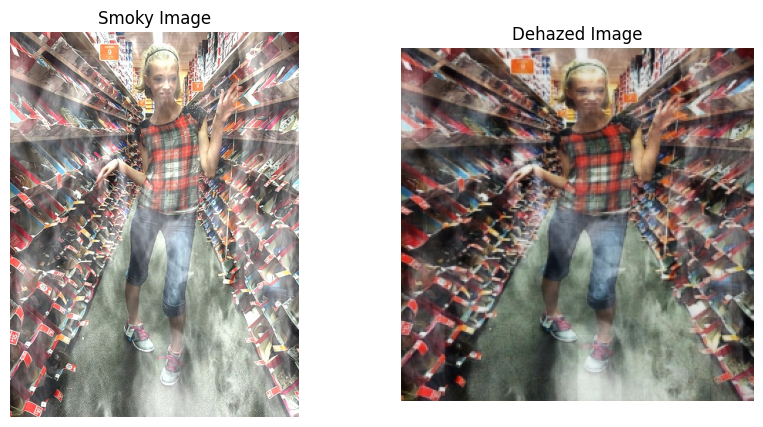

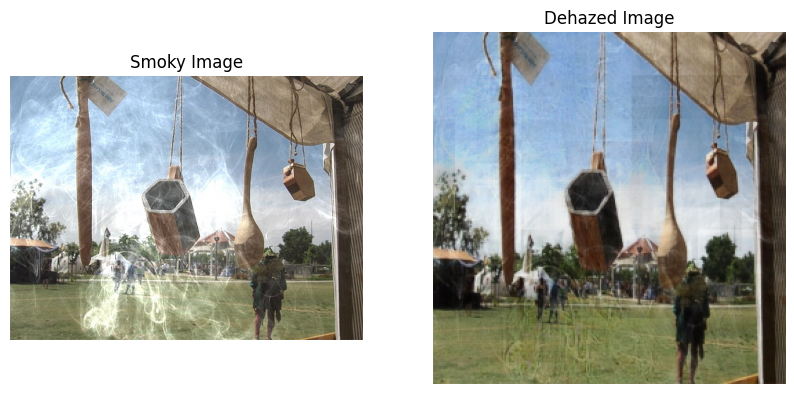

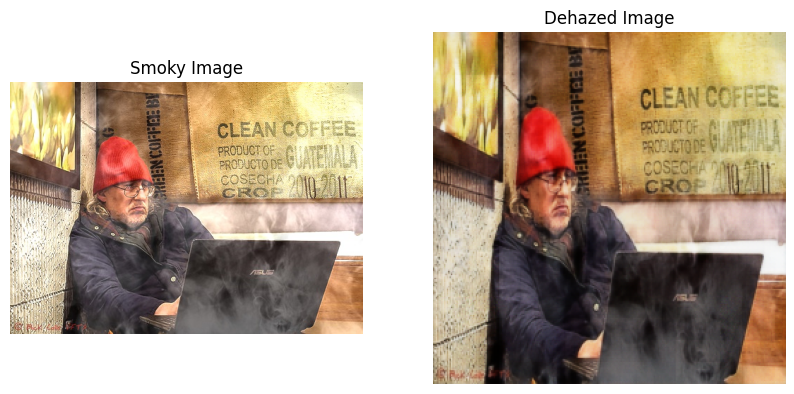

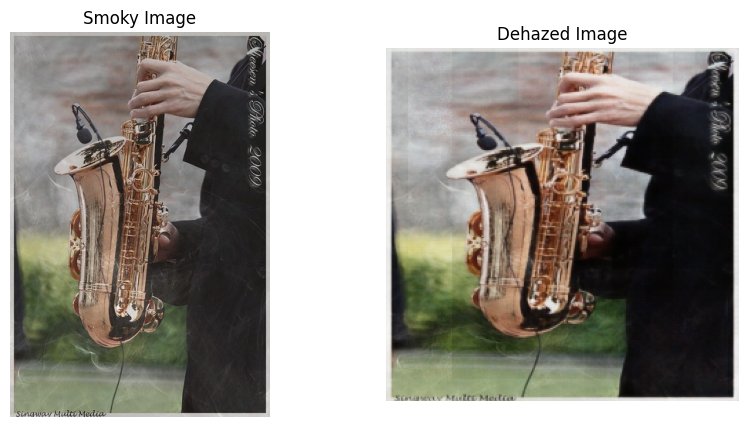

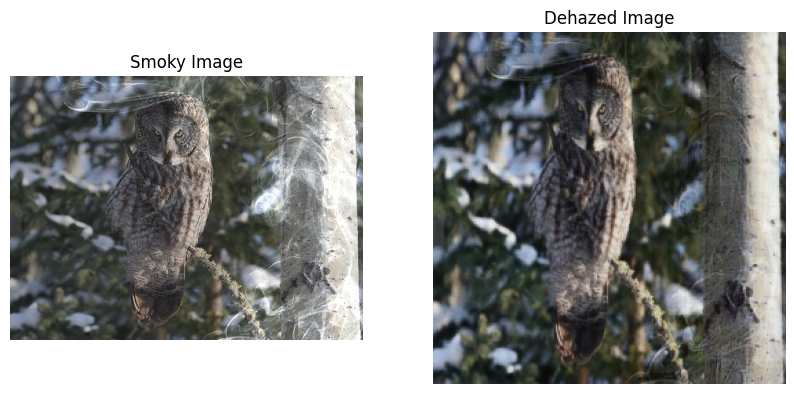

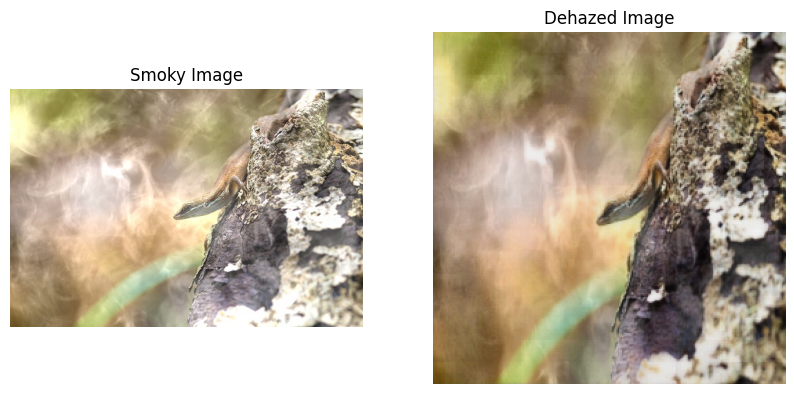

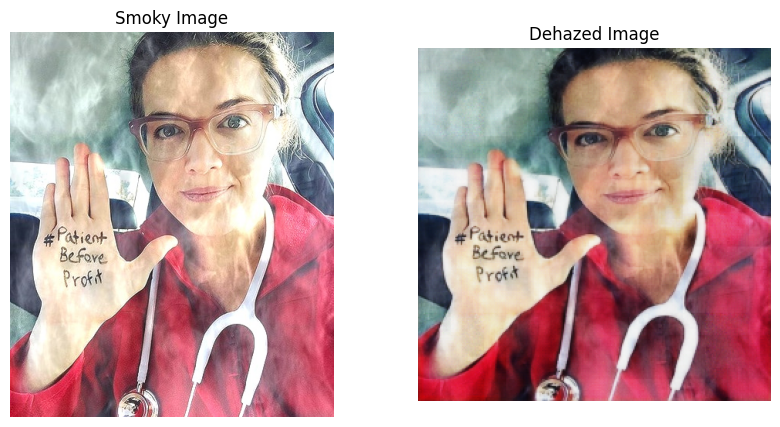

In [35]:
lst = ['1', '2', '3', '4', '6', '7', '8']
for i in lst:
    if i == '2' or i == '4' or i == '6':
        test_model_on_image('/kaggle/input/testing3/img_' + i + '.jpg')
    else:
        test_model_on_image('/kaggle/input/testing3/img_' + i + '.jpeg')
        
    